# Прогнозирование заказов таксти

## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания. Значение метрики RMSE на тестовой выборке должно быть не больше 48.
    
## План работы

1. Загрузите данные и выполните их ресемплирование по одному часу.

2. Проанализируйте данные.

3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.

4. Проверьте модель на тестовой выборке и сделайте выводы.

## Загрузка и ресемплирование данных

###  Загрузка библиотек

In [ ]:
!pip install catboost -q
!pip install lightgbm -q
!pip install --upgrade scikit-learn -q

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder


from  sklearn.dummy import DummyRegressor
from sklearn.linear_model import (
    LinearRegression,
    Lasso,
    Ridge,
    SGDRegressor)
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.metrics import mean_squared_error

In [ ]:
import warnings
warnings.filterwarnings('ignore')

### Загрузка и ознакомление с данными

Загрузим датасет в переменную, а также сразу превратив колонку датой в индексы.

In [ ]:


try:
    df = pd.read_csv('/datasets/taxi.csv', parse_dates=['datetime'], index_col = 'datetime')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', parse_dates=['datetime'], index_col = 'datetime')

Выведем первые 5 строк

In [ ]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Данные выглядят загруженными корректно

Просмотрим на тип данных и наличие пропусков

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Тип данных соответсвует содержанию. В данных отсутсвуют пропуски

Проверим наличие дубликатов в индексах

In [ ]:
df.index.duplicated().sum()

0

Дубликаты в индексах остутствуют

Теперь убедимся в том, что временной ряд упорядочен

In [ ]:
if (df.index.is_monotonic):
    print('Временной ряд не упорядочен')
else:
    print('Временной ряд упорядочен')

Временной ряд не упорядочен


Проверим наличие выбросов в данных. Для этого построим распределение по временному ряду.

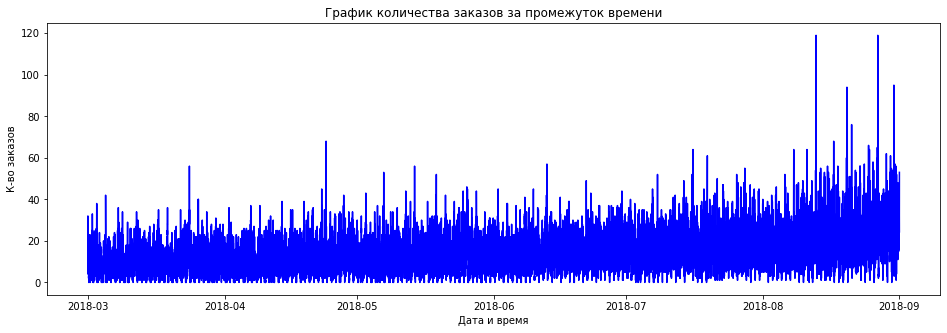

In [ ]:
plt.figure(figsize=(16, 5))
plt.plot( df['num_orders'], color='blue')
plt.title('График количества заказов за промежуток времени')
plt.xlabel('Дата и время')
plt.ylabel('К-во заказов')
plt.show()

Таким образом мы видем, что значительно выбивающихся из общей картины данных не наблюдается

###  Ресемплирование данных

Теперь проведем ресемплирование данных по одному часу

In [ ]:
df_res = df.resample('1H').sum()
df_res.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Теперь данные разделены 60 минутным временным промежутком, а не 10 минутным, как было раньше

Отчистим память от ненужной переменной

In [ ]:
del df

### Вывод

* Данные загружены без ошибок
* Тип данных соответсвует содержанию
* В данных отсутсвуют пропуски
* Дублекаты временных отрезков отсутсвуют
* Временные отрезки упорядочены
* Выбросы в данных отсутствуют
* Проведено ресемплирование данных по одному часу

## Анализ данных

### Распределение  временного ряда

Построим гистрограмму распределения временных рядов с целью выявления закономерностей

In [ ]:
def feed_info(df,column, x, y, bins):
    #(2 строки, 1 столбец)
    fig, axs = plt.subplots(2, 1, figsize=(5, 7))

    # Верхний график - гистограмма
    axs[0].hist(df[column], bins=bins)
    axs[0].set_title(f'Распределение по {column}')
    axs[0].set_xlabel(x)
    axs[0].set_ylabel(y)
    axs[0].grid(True)

    # Нижний график - ящик
    boxplot = sns.boxplot(data=df, x=column, ax=axs[1])
    boxplot.set_title(f'Ящик с усами для {column}')

    # Располагает графики более компактно
    plt.tight_layout()
    plt.show()

    # Теперь выведем общую статистику
    print(f'Статистика по {column}:')
    print(df[column].describe())

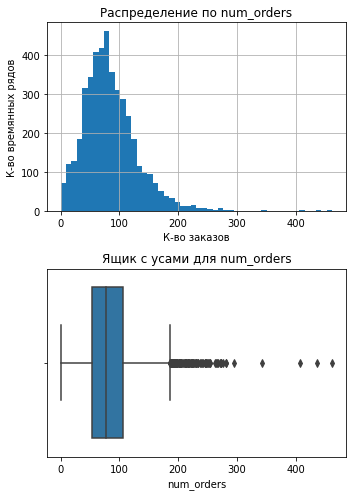

Статистика по num_orders:
count    4416.000000
mean       84.422781
std        45.023853
min         0.000000
25%        54.000000
50%        78.000000
75%       107.000000
max       462.000000
Name: num_orders, dtype: float64


In [ ]:
feed_info(df_res,'num_orders','К-во заказов','К-во времянных рядов', 50)

* Наиболее часто к-во заказов в диапазоне между 54 и 107 за час
* Более 200 заказов за час можно считать аномальным количеством
* Бывают времянные промежутки полного отсутствия заказов
* Среднее значение заказов блико к медианному. Это говорит о том, что данные распределены относительно равномерно вокруг центра, и аномалии не оказывают существенного влияния
* Внешний вид распределения напоминает гамма распределение

### Тренд временного ряда

Для дальнейшей работы подготовим переменную, которая будет содержать в себе тренд, сезонность и остаток временного ряда

In [ ]:
df_dec = seasonal_decompose(df_res)

**Тренд** (англ. trend) — плавное изменение среднего значения ряда без повторяющихся закономерностей. Например, ежегодное увеличение объёма продаж авиабилетов.

Подготовим функцию отображения шума временного ряда, с помощью которой мы получим график, показывающий случайные колебания в данных, не связанные с трендом или сезонностью.

In [ ]:
def trend_ts(df, title='Тренд времянного ряда', xlabel='Период', ylabel='Средний тренд'):
    plt.figure(figsize=(16, 5))
    df.trend.plot(linestyle='-', color='blue')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)

Ознакомимся с трендом за весь период

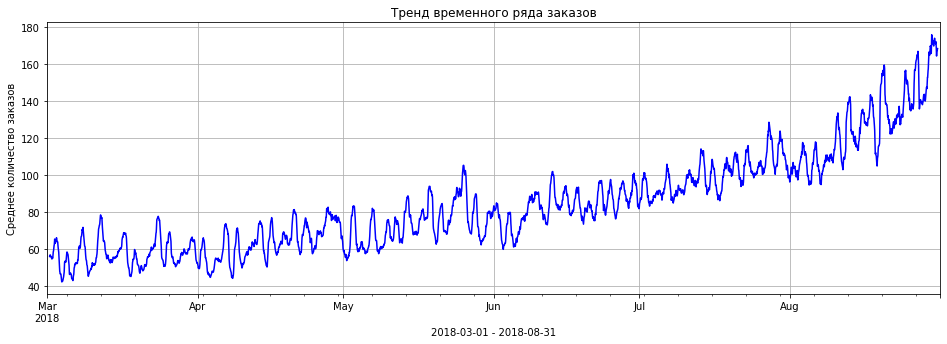

In [ ]:
trend_ts(df_dec, 'Тренд временного ряда заказов', '2018-03-01 - 2018-08-31', 'Среднее количество заказов')

Количество заказов демонстрирует устойчивый рост с каждым месяцем. Однако, основываясь на данных только за текущий год, мы не можем с уверенностью утверждать, что эта тенденция обусловлена факторами времени года. Вполне вероятно, что наблюдаемый рост связан с растущей популярностью сервиса среди пользователей.

### Сезонность  временного ряда

**Сезонность** (англ. seasonality) — циклично повторяющиеся закономерности во временном ряду. Допустим, рост продаж авиабилетов летом.

Теперь напишем функцию для получния графика, который показывает, как изменяется сезонность на протяжении всего периода.

In [ ]:
def season_ts(df, title='Сезонность времянного ряда', xlabel='Период', ylabel='Сезонность'):
    plt.figure(figsize=(16, 5))
    df.seasonal.plot(linestyle='-', color='blue')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)

In [ ]:
def season_ts_interval(df, left=None, right=None, title='Сезонность времянного ряда', xlabel='Период', ylabel='Сезонность'):
    plt.figure(figsize=(16, 5))
    df[left:right].plot(linestyle='-', color='blue')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)

Для начала ознакомимся с сезонностью за весь период

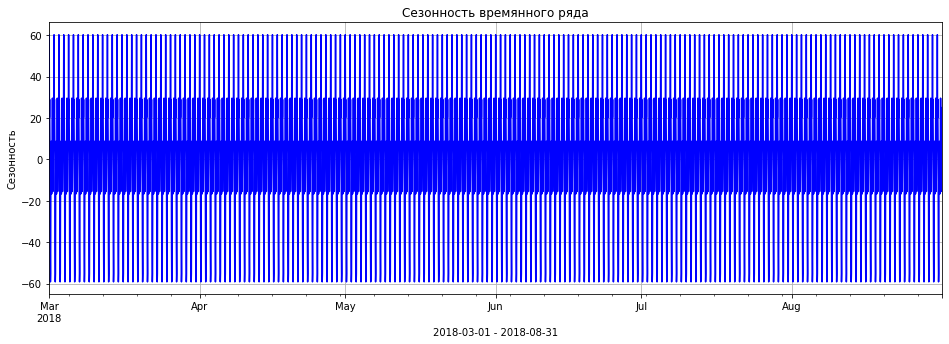

In [ ]:
season_ts(
    df_dec,
    xlabel='2018-03-01' + ' - ' + '2018-08-31'
)

Частота колебаний сезонности слишком велика для такого масштаба данных. Попробуем переид длительностью в две недели начиная с понедельника по воскресенье последних полных недель периода.

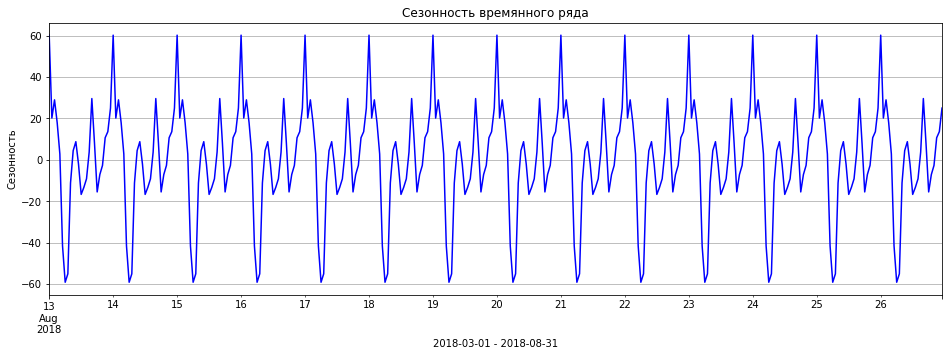

In [ ]:
season_ts_interval(
    df_dec.seasonal,
    '2018-08-13',
    '2018-08-26',
    xlabel='2018-03-01' + ' - ' + '2018-08-31')

По всей видимости сезонность связана с периодом длительностью один день. Недельной сезонности не наблюдается. Построим сезонность предпоследнего полного дня общего периода, а также захватим пару часов от соседних дней.

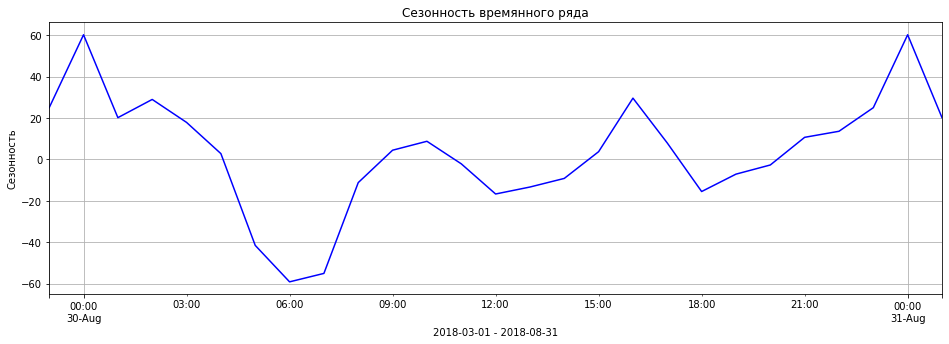

In [ ]:
season_ts_interval(
    df_dec.seasonal,
    '2018-08-29 23:00:00',
    '2018-08-31 01:01:01',
    xlabel='2018-03-01' + ' - ' + '2018-08-31')

Анализ сезонности заказов выявил четкие суточные ритмы

**Пик активности наблюдается в ночное время, с 20:00 до 4:00.**
Это говорит о том, что люди, вероятно, оформляют заказы после работы, отдыхают и возвращаются домой к утру

Спад активности наблюдается в следующих временных интервалах:

* **4:00 - 9:00**: Большинство людей в это время находятся дома и спят
* **10:00 - 15:00**: Этот период может быть связан с работой, учебой или другими делами, которые не подразумевают перемещение на транспорте
* **17:00 - 19:00**: Вероятнее всего, в этот период люди находятся в пути с работы домой или на других делах и пользуются личным и общественным транспортом

**Пик активности в районе 16:00** требует дополнительного изучения. Возможно, он связан с определенными событиями или характерными для этой группы пользователей привычками

### Остатки временного ряда

**Остаток** (англ. residuals) — это компонента, которая не объясняется трендом и сезонностью, это шум.

Подготовим функцию отображения остатков времянного ряда, с помощью которой мы получаем график, который показывает, как изменялся средний уровень заказов на протяжении всего периода.

In [ ]:
def resid_ts(df, title='Шум временного ряда', xlabel='Период', ylabel='Остатки'):
    plt.figure(figsize=(16, 5))
    df.resid.plot(linestyle='-', color='blue')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)

In [ ]:
def resid_ts_interval(df, left=None, right=None, title='Шум временного ряда', xlabel='Период', ylabel='Остатки'):
    plt.figure(figsize=(16, 5))
    df[left:right].plot(linestyle='-', color='blue')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)

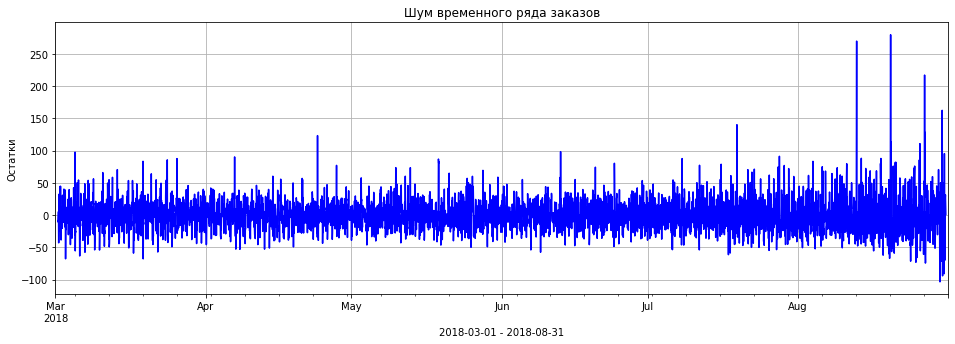

In [ ]:
resid_ts(df_dec, 'Шум временного ряда заказов', '2018-03-01 - 2018-08-31', 'Остатки')

* Частота колебания шума очень высокая, что свидетельствует о частых и быстрых изменениях в данных
* Амплитуда колебаний относительно равномерна, что указывает на стабильность уровня шума

Попробуем ознакомиться с более короткими временными диапазонами. Возьмем диапазон последних двух недель периода

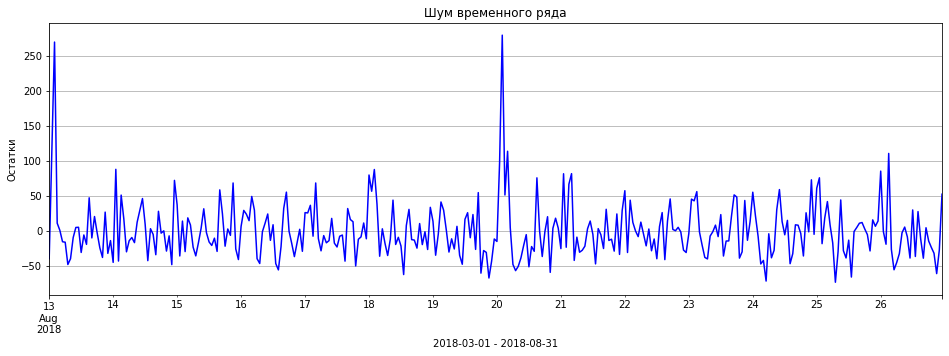

In [ ]:
resid_ts_interval(
    df_dec.resid,
    '2018-08-13',
    '2018-08-26',
    xlabel='2018-03-01' + ' - ' + '2018-08-31')

Каких-то новых наблюдений и закономерностей не наблюдается. Стало очевидно, что аплетуда калебания не стабильна, а частота колебаний высока

In [ ]:
del df_dec

### Стационарность временного ряда

Проверим стационарность временного ряда, которая позволяет оценить прогнозируемость данных. Для этого нарисуем графики: **временного ряда, скользящего среднего и скользящего стандартного отклонения**. Если среднее и стандартное отклонение не будут меняться, тогда можно ряд будет стационарным. В противном случае придется производить преобразования над данными, а именно находить **разности временного ряда**, которая должна будт позволить получить более стационарный ряд

In [ ]:
def stationarity(df, column, points=10):
    plt.figure(figsize=(16, 6))
    # График исходных данных
    plt.plot(df.index, df[column], label='Исходные данные', color='blue')
    # График скользящего среднего
    plt.plot(df_res.index, df_res.rolling(points).mean(), label=f'Скользящее среднее ({points} точек)', color='red')
    # График скользящего стандартного отклонения
    plt.plot(df_res.index, df_res.rolling(points).std(), label=f'Скользящее стандартное отклонение ({points} точек)', color='green')

    plt.xlabel('Дата')
    plt.ylabel('Количество заказов')
    plt.title('Исходные данные, скользящее среднее и стандартное отклонение')
    plt.legend()

    plt.show()

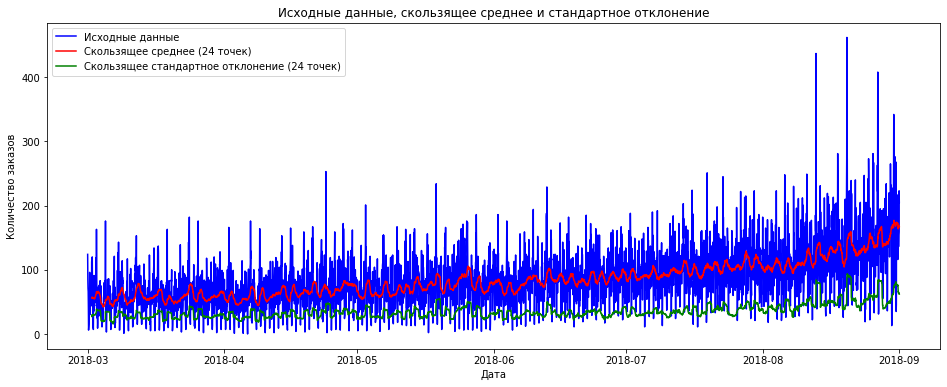

In [ ]:
stationarity(df_res, 'num_orders', 24)

Таким образом мы видим, что скользящее среднее подвержено измененям. Скользящее стандартное отклонение подвержено в меньшей степени. Построим временного ряда разности соседних элементов исходного ряда и проверим его стационарность

In [ ]:
def_diff = df_res - df_res.shift(fill_value=0)

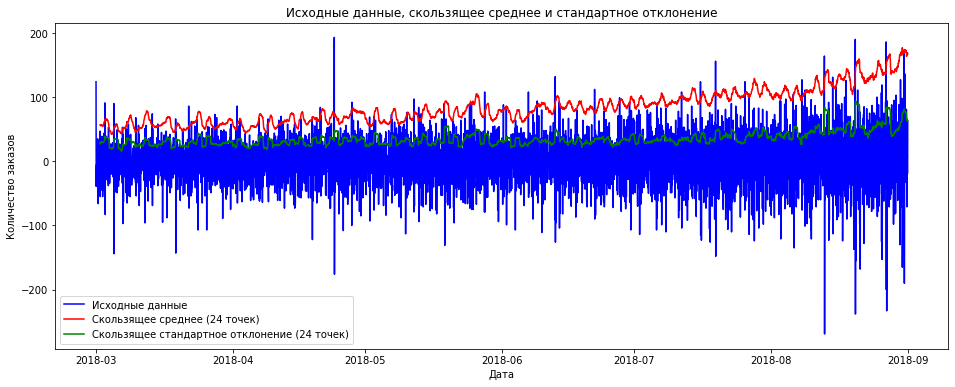

In [ ]:
stationarity(def_diff, 'num_orders', 24)

Полученный ряд не является более стационарным, чем предыдущий. Тогда оставим исходный

In [ ]:
del def_diff

###  Вывод

* В данных могут присутсвовать аномальное количество заказов, поэтому стоит обрать внимание на линейные модели с регуляризацией, а также не линейные модели
* На протяжении всего времени присутсвует тренд на увеличение среднего количества заказов и нет оснований пологать, что он связан с временами года. Для того, чтобы акцентировать внимание модели на тренде следует всять среднее скользящее хотя бы длительностью в неделю
* Наблюдается четкая сезонность в течении дня, ввиду этого при моделировании стоит обратить внимание на предыдущие значения в этот временной промежуток
* Остатки не позволяют нам выявить закономерности
* Cкользящее среднее подвержено измененям, cкользящее стандартное отклонение также подвержено изменением, из чего следует нестационарность ряда, что указивает на возможные трудности прогнозирования. Таким образом это говорит нам о том, что следует обратить внимание на нелинейные модели

## Обучение моделей

### Подготовка данных

Подготовим функцию для получения признаков из исходных данных

In [ ]:
def make_features(data=None, max_lag=1, rolling_mean_size=1):
    data['year'] = data.index.year
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data.dropna()

Используем функцию получения признаков и создадим признаки 24 предыдущих часов, а также скользящее среднее последней недели

In [ ]:
df = make_features(df_res, 168, 168)
del df_res
y = df['num_orders'].copy()
X = df.drop(columns=['num_orders']).copy()
num_columns = X.columns

ohe_columns = ['hour', 'dayofweek']
num_col_linal = num_columns.drop(['hour', 'dayofweek'])


Установим случайное число

In [ ]:
RANDOM_STATE = 42

Разделим вуборки на тестовую и тренировочную

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    shuffle=False,
                                                    test_size=0.1,
                                                    random_state=RANDOM_STATE)

### Подготовка кросс-валидации

Подготовим пайплайны предобработки и моделирования

In [ ]:
data_preprocessor = ColumnTransformer(
    [
        (
            'num',
            StandardScaler(), num_columns
        )
    ],
    remainder='passthrough'
)

ohe_pipeline_linal = Pipeline(
    [
        (
            'encoder',
            OneHotEncoder(drop='first', handle_unknown='error', sparse_output=False)
        )
    ]
)

data_preprocessor_linal = ColumnTransformer(
    [
        (
            'ohe',
            ohe_pipeline_linal, ohe_columns
        ),
        (
            'num',
            StandardScaler(), num_col_linal
        )
    ],
    remainder='passthrough'
)

pipe_final = Pipeline(
    [
        (
            'preprocessor',
            data_preprocessor
        ),
        (
            'models',
            DummyRegressor()
        )
    ]
)

Подготовим модели и список параметров

In [ ]:
param_grid = [

    {
        'models': [DummyRegressor()],
        'preprocessor':[data_preprocessor_linal]
    },

    {
        'models': [Lasso()],
        'models__max_iter': [RANDOM_STATE],
        'models__max_iter': [1000],
        'models__alpha':[1, 0.001],
        'preprocessor':[data_preprocessor_linal]
    },

    {
        'models': [Ridge()],
        'models__max_iter': [RANDOM_STATE],
        'models__max_iter': [1000],
        'models__alpha':[1, 0.001],
        'preprocessor':[data_preprocessor_linal]
    },

    {
        'models': [SGDRegressor()],
        'models__max_iter': [RANDOM_STATE],
        'models__max_iter': [1000],
        'preprocessor':[data_preprocessor_linal]
    },

    {
        'models': [LGBMRegressor()],
        'models__verbose': [-100],
        'models__random_state': [RANDOM_STATE],
        'models__n_jobs': [-1],
        'models__boosting_type': ['gbdt', 'rf'],
        'models__n_estimators': [100, 400],
        'models__learning_rate': [0.01, 0.1]
    },

    {
        'models': [CatBoostRegressor()],
        'models__verbose': [False],
        'models__random_state': [RANDOM_STATE],
        'models__n_estimators': [500, 1000],
        'models__learning_rate': [0.01, 0.1],
        'models__boosting_type': ['ordered', 'plain']
    }
]

Подготовим специальное разделение временных рядов

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)

Подготовим переменную кросс-валидации

In [ ]:
gs = GridSearchCV(
    pipe_final,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_root_mean_squared_error'
)

### Кросс-валидация и вывод лучших

Запустим кросс-валидацию

In [ ]:
gs.fit(X_train, y_train);

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .

[LightGBM] [Fatal] Check 

In [ ]:
result = pd.DataFrame(gs.cv_results_)
print('Рейтинг лучших моделей по производительности, а также среднее время обучения')
display(result[
    ['rank_test_score', 'param_models', 'mean_test_score', 'mean_fit_time', 'mean_score_time']
].sort_values('rank_test_score')[['param_models', 'mean_test_score', 'mean_fit_time', 'mean_score_time']].round(2).head(10))

Рейтинг лучших моделей по производительности, а также среднее время обучения


,param_models,mean_test_score,mean_fit_time,mean_score_time
1,Lasso(),-22.12,0.23,0.17
3,Ridge(),-22.76,0.23,0.14
5,SGDRegressor(),-22.85,0.16,0.06
7,LGBMRegressor(),-23.07,18.34,0.06
8,LGBMRegressor(),-23.18,4.45,0.01
2,Lasso(),-23.20,4.14,0.18
4,Ridge(),-23.29,0.22,0.18
9,LGBMRegressor(),-23.33,16.50,0.08
6,LGBMRegressor(),-27.24,6.74,0.02
0,DummyRegressor(),-40.68,0.02,0.01


Лучше всего с задачей справилась модель градиентного бустинга

## Проверка модели на тестовой выборке

Отобразим лучшие гиперпараметры

In [ ]:
gs.best_params_

{'models': Lasso(),
 'models__alpha': 1,
 'models__max_iter': 1000,
 'preprocessor': ColumnTransformer(remainder='passthrough',
                   transformers=[('ohe',
                                  Pipeline(steps=[('encoder',
                                                   OneHotEncoder(drop='first',
                                                                 sparse_output=False))]),
                                  ['hour', 'dayofweek']),
                                 ('num', StandardScaler(),
                                  Index(['year', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7',
        'lag_8', 'lag_9',
        ...
        'lag_160', 'lag_161', 'lag_162', 'lag_163', 'lag_164', 'lag_165',
        'lag_166', 'lag_167', 'lag_168', 'rolling_mean'],
       dtype='object', length=170))])}

Проведем предстказания на тестовой выборке

In [ ]:
y_pred_final = gs.best_estimator_.predict(X_test)

Получим метрику качества RMSE работы модели на тествой выборке

In [ ]:
print(f'RMSE лучшей модели на тестовой выборке:')
mean_squared_error(y_pred=y_pred_final, y_true=y_test, squared=False)

RMSE лучшей модели на тестовой выборке:


34.79166114110486

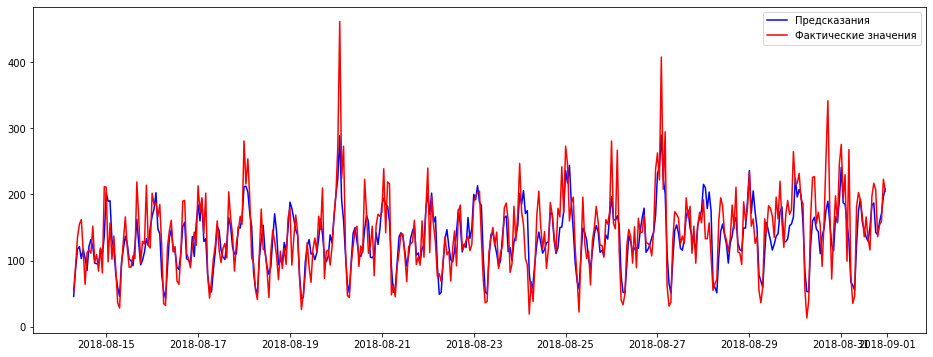

In [ ]:
y_pred_final = pd.Series(y_pred_final, index=y_test.index)

plt.figure(figsize=(16, 6))
plt.plot(y_pred_final.index, y_pred_final, 'b-', label='Предсказания')
plt.plot(y_test.index, y_test, 'r-', label='Фактические значения')
plt.legend()  # Добавьте легенду для удобства
plt.show()

## Вывод

В ходе работы были мы выгрузили данные и подготовили их к анализу. Подготовка включала в себя проверку непрерывности и дубликатов, выявление выбросов и соответвие содержимого заданию и типам данных. Кроме того было проведено ресемплирование данных по часам.

Далее был проведен анализ времянных рядов. В анализ входило изучение распределение времянного ряда, определение роли трендов, сезонности и остатков для задачи. Также была проведена проверка стационарности ряда. В ходе анализа была выявлена нестационарность и сезонность в течении дня. На основе анализа временного ряда были созданы признаки для дальнейшего моделирования.

В конечном счете было проведено обучение моделей с целью предсказания временного ряда с наибольшей точностью. В ходе обучения моделей перебирались различные комбинации гиперпараметров. Модель с лучшими гиперпараметрами была проверена на тестовой выборке и выдала высокие показатели по требованиям заказчика.